In [1]:
### read raw images and landmarks

%matplotlib inline
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

muct_data_path = '/Users/azhong/face/clmtools/pdm_builder/data/images/'
muct_annotation_path = '/Users/azhong/face/clmtools/pdm_builder/data/annotations.csv'

landmark_dict = {}
raw_image_dict = {}
image_dict = {}
mouth_dict = {}
mouth_openness_absolute = {}
image_array = []
landmarks_array = []
image_dim_dict = {}
mouth_landmarks = range(44, 62)

with open(muct_annotation_path) as fi:
    for line in fi:
        splitted = line.split(';')
        filename = os.path.join(muct_data_path, splitted[0])
        if os.path.isfile(filename):
            landmark_dict[splitted[0]] = [[float(splitted[i*3+1]), float(splitted[i*3+2])] for i in range(71)]
            landmark_dict[splitted[0]] = np.array(landmark_dict[splitted[0]])
            raw_image_dict[splitted[0]] = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2GRAY)
            image_dim_dict[splitted[0]] = raw_image_dict[splitted[0]].shape

In [2]:
### augment images (randomly rotate/scale/translate)

import random
import math
augment_count = 5
random.seed()
for i in sorted(landmark_dict.keys()):
    x2, y2 = np.amax(landmark_dict[i], axis=0)
    x1, y1 = np.amin(landmark_dict[i], axis=0)
    x1 = int(x1)
    x2 = int(x2)
    # extend up further to forehead
    y1 = max(int(y1 - (y2-y1)*0.2), 0)
    y2 = int(y2)
    
    mouth_left_x, mouth_left_y = landmark_dict[i][44]
    mouth_right_x, mouth_right_y = landmark_dict[i][50]
    
    for j in range(augment_count):
        x11 = x1
        y11 = y1
        x22 = x2
        y22 = y2

        if y22 - y11 > x22 - x11:
            diff = (y22 - y11 - (x22 - x11))/2.0
            x111 = max(int(x11-diff), 0)
            x222 = min(int(x22+diff), image_dim_dict[i][1])
            y111 = int(y11)
            y222 = int(y22)
        else:
            diff = (x22 - x11 - (y22 - y11))/2.0
            y111 = max(int(y11-diff), 0)
            y222 = min(int(y22+diff), image_dim_dict[i][0])
            x111 = int(x11)
            x222 = int(x22)

        # randomly rotate image by -10 to 10 degrees
        angle = (random.random()*2-1)*10
        # randomly scale image 0.9-1.1
        ratio = (random.random()*2-1)*0.1 + 1
        translate_x = int(np.round((random.random()*2-1) * 0.10 * 32))
        translate_y = int(np.round((random.random()*2-1) * 0.10 * 16))

        mouth_center = ((mouth_left_x+mouth_right_x)/2.0, 
                        (mouth_left_y+mouth_right_y)/2.0)
        M = cv2.getRotationMatrix2D(((mouth_left_x+mouth_right_x)/2, 
                                     (mouth_left_y+mouth_right_y)/2), angle, ratio)
        rotated_image = cv2.warpAffine(raw_image_dict[i], M, (image_dim_dict[i][1], image_dim_dict[i][0]))
#         print('angle ', angle, 'ratio', ratio, 'x', translate_x, 'y', translate_y)
#         plt.imshow(raw_image_dict[i], cmap='gray')
#         plt.show()
#         plt.imshow(rotated_image, cmap='gray')
#         plt.show()

        mod_image_resized = cv2.resize(rotated_image[y111:y222, x111:x222], (64, 64))
        mouth_center_resized = ((mouth_center[0]-x111)/(x222-x111)*64, (mouth_center[1]-y111)/(y222-y111)*64)
        center_x, center_y = (int(mouth_center_resized[0]), int(mouth_center_resized[1]))
##        cv2.circle(mod_image_resized, (int(mouth_center_resized[0]), int(mouth_center_resized[1])), 2, (255))
#         plt.imshow(mod_image_resized, cmap='gray')
#         plt.show()
        image_dict[i + '_augment_' + str(j*2)] = mod_image_resized
        image_dict[i + '_augment_' + str(j*2+1)] =  np.fliplr(mod_image_resized)

        blank = mod_image_resized.copy()
        blank.fill(127.5)
        
        for ii in range(max(0, center_x-16), min(center_x+16, 63)):
            for jj in range(max(0, center_y-8), min(center_y+8, 63)):
                blank[jj - max(center_y-8, 0) + 40][ii-max(0, center_x-16)+16] = mod_image_resized[jj+translate_y][ii+translate_x]

        mouth_dict[i + '_augment_' + str(j*2)] = blank
        mouth_dict[i + '_augment_' + str(j*2+1)] = np.fliplr(blank)
        
        mouth_openness_absolute_x = (landmark_dict[i][57][0] - landmark_dict[i][60][0]) / (x222-x111) * 64 * ratio
        mouth_openness_absolute_y = (landmark_dict[i][57][1] - landmark_dict[i][60][1]) / (y222-y111) * 64 * ratio
        mouth_openness_absolute[i + '_augment_' + str(j*2)] = np.linalg.norm(np.array([mouth_openness_absolute_x, mouth_openness_absolute_y]))
        mouth_openness_absolute[i + '_augment_' + str(j*2+1)] = np.linalg.norm(np.array([mouth_openness_absolute_x, mouth_openness_absolute_y]))
        
#         plt.imshow(blank, cmap = 'gray')
#         plt.show()
#         plt.imshow(np.fliplr(blank), cmap = 'gray')
#         plt.show()


In [3]:
mouth_openness_top_down = {}
mouth_openness_left_right = {}

for i in sorted(landmark_dict.keys()):
    left_right = np.linalg.norm(landmark_dict[i][44] - landmark_dict[i][50])                  
    top_down   = np.linalg.norm(landmark_dict[i][47] - landmark_dict[i][53])
    openness   = np.linalg.norm(landmark_dict[i][57] - landmark_dict[i][60])
    if openness/left_right >= 0.1:
        mouth_openness_left_right[i] = openness/left_right
    else:
        mouth_openness_left_right[i] = 0
    if openness/top_down >= 0.1: 
        mouth_openness_top_down[i]   = openness/top_down
    else:
        mouth_openness_top_down[i]   = 0

In [4]:
import tensorflow as tf
emotion_model_path = '../tensorflow/models/emotion_mini_XCEPTION_64x64_0.66_7ms.hdf5.pb'
graph = tf.Graph()
graph_def = tf.GraphDef()
with open(emotion_model_path, "rb") as f:
    graph_def.ParseFromString(f.read())
with graph.as_default():
    tf.import_graph_def(graph_def)
input_name = 'import/input_1'
output_add_name = 'import/add_4/add'
output_conv_name = 'import/conv2d_7/BiasAdd'
output_name = 'import/output_node0'

input_operation = graph.get_operation_by_name(input_name)
output_add_operation  = graph.get_operation_by_name(output_add_name)
output_conv_operation = graph.get_operation_by_name(output_conv_name)
output_operation = graph.get_operation_by_name(output_name)

input_shape = (int(input_operation.outputs[0].shape.dims[1]),
               int(input_operation.outputs[0].shape.dims[2]),
               1)

add_dict = {}
mean_of_add_dict = {}
conv_dict = {}
output_dict = {}
add_sampled_dict = {}
sess = tf.Session(graph = graph)
for i in sorted(mouth_dict.keys()):
    gray_face = (mouth_dict[i] - 127.5) / 127.5
    gray_face = np.expand_dims(gray_face, 0)
    gray_face = np.expand_dims(gray_face, -1)
    prediction = sess.run([output_add_operation.outputs[0], output_conv_operation.outputs[0], output_operation.outputs[0]],
                          {input_operation.outputs[0]: gray_face})
    add_out = prediction[0][0]
    add_out = add_out.reshape(16, 128)
    mean_of_add_out = np.mean(add_out, axis=0)
    add_out = add_out.reshape(2048)
    add_dict[i] = add_out.copy()
    add_sampled_dict[i] = [add_out[j] for j in [728, 1749, 1741, 1914]]
    mean_of_add_dict[i] = mean_of_add_out.copy()
    conv_dict[i] = prediction[1][0].reshape(112)
    output_dict[i] = prediction[2][0]

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
# preparing SVM

X = []
y_left_right = []
y_top_down = []
y_absolute = []

sorted_keys = sorted(mouth_dict.keys())
np.random.shuffle(sorted_keys)
# shuffle
for i in sorted_keys:
    X.append(list(add_dict[i]))
    filename = i.split('_augment_')[0]
    y_left_right.append(mouth_openness_left_right[filename])
    y_top_down.append(mouth_openness_top_down[filename])
    y_absolute.append(mouth_openness_absolute[i])

from sklearn import svm
from sklearn.model_selection import cross_val_score
clf_0 = svm.LinearSVR()
clf_1 = svm.LinearSVR()
clf_2 = svm.LinearSVR()

total_size = len(X)
print('total size is {}'.format(total_size))
train_size = int(0.8*total_size)

print('top down mouth open ratio')
print(cross_val_score(clf_0, X, y_top_down, scoring='neg_mean_absolute_error'))

print('left right mouth open ratio')
print(cross_val_score(clf_1, X, y_left_right, scoring='neg_mean_absolute_error'))

print('absolute mouth openness in pixels')
print(cross_val_score(clf_2, X, y_absolute, scoring='neg_mean_absolute_error'))


#cross_val_score(clf, X, y, scoring='neg_mean_absolute_error') 
clf_0.fit(X, y_top_down)
clf_1.fit(X, y_left_right)
clf_2.fit(X, y_absolute)

print(clf_0.score(X, y_top_down))
print(clf_1.score(X, y_left_right))
print(clf_2.score(X, y_absolute))

total size is 5110
top down mouth open ratio
[-0.08985995 -0.09510303 -0.09228775]
left right mouth open ratio
[-0.05188474 -0.07319056 -0.05202475]
absolute mouth openness in pixels
[-0.84608506 -0.89872536 -0.84876263]
0.8371961157268301
0.9282827687367852
0.908077069344158


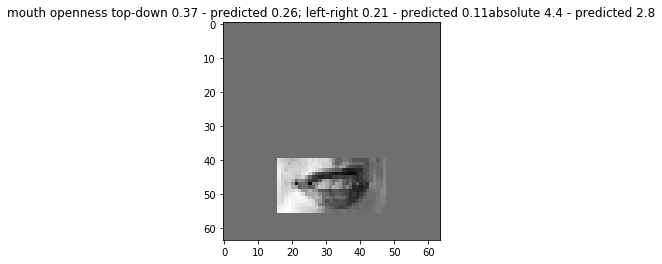

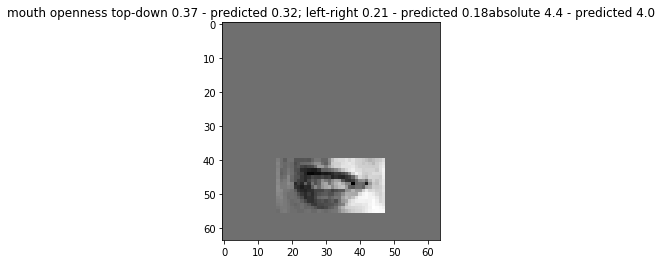

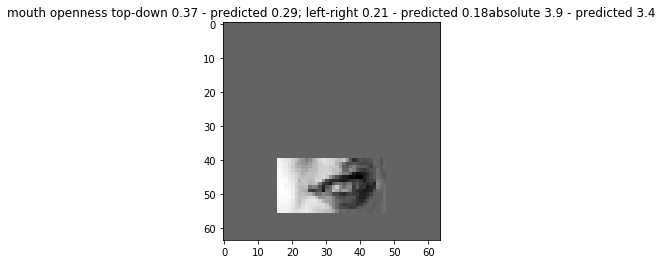

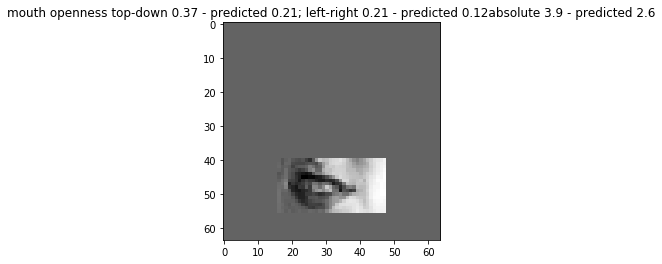

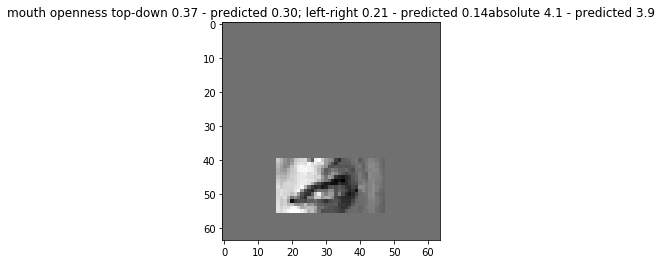

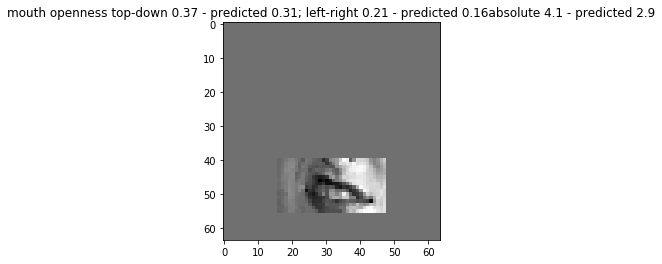

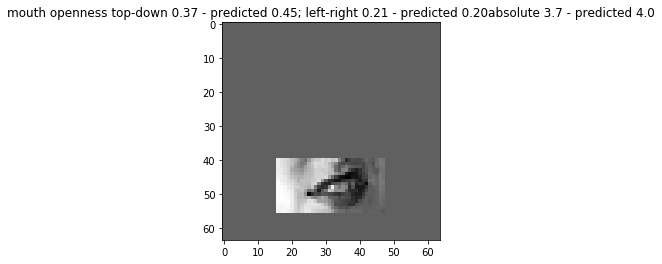

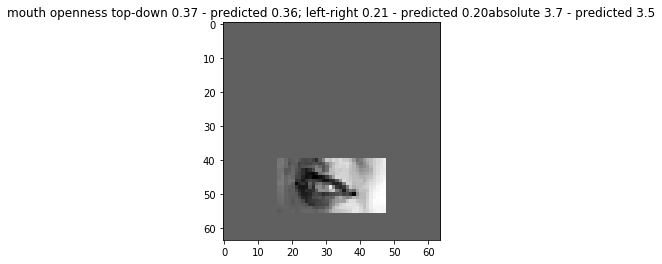

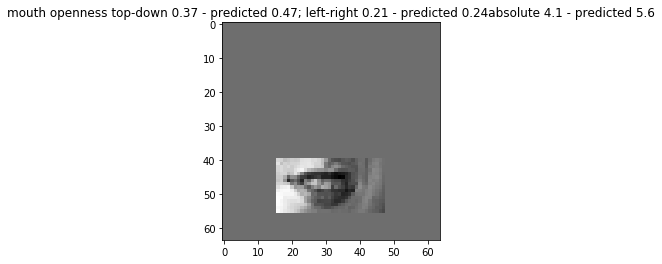

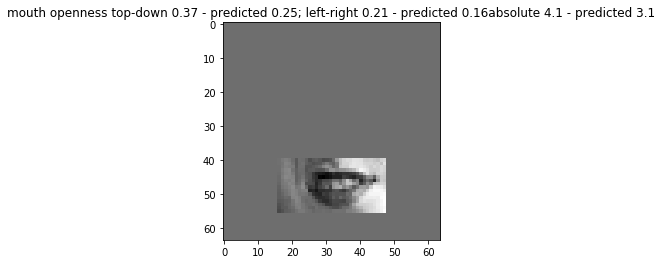

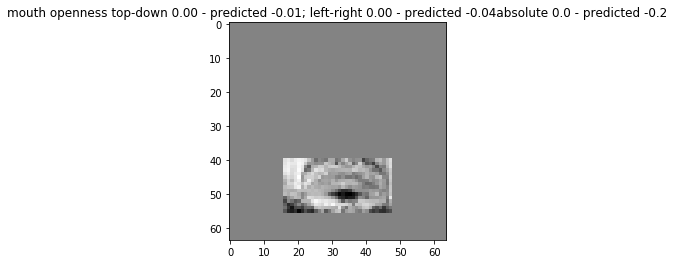

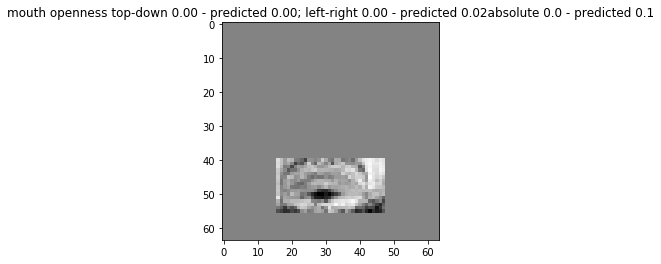

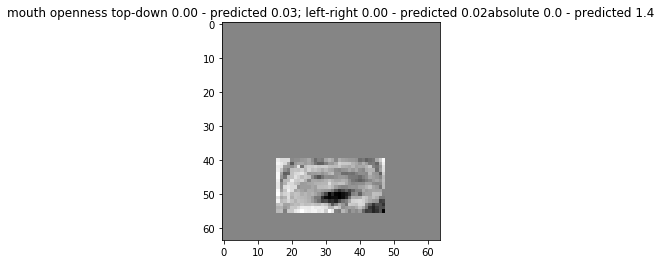

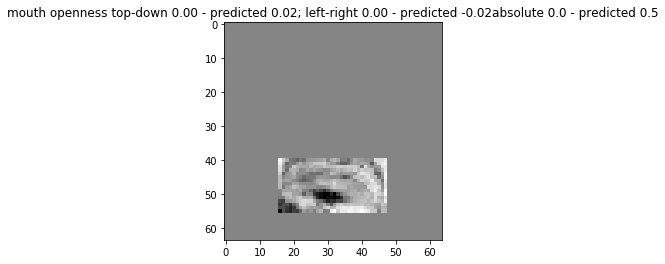

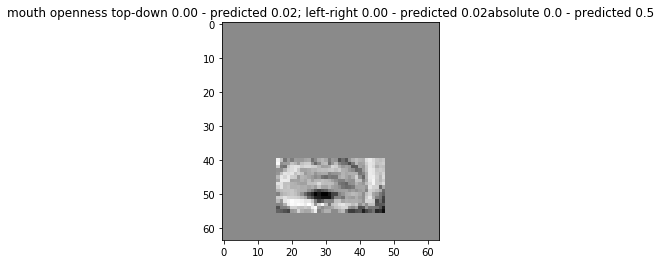

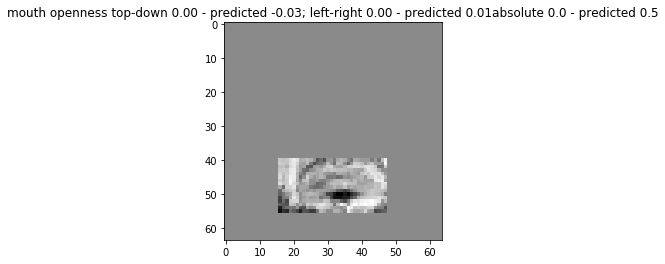

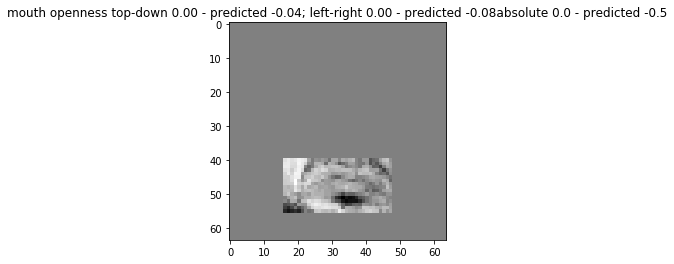

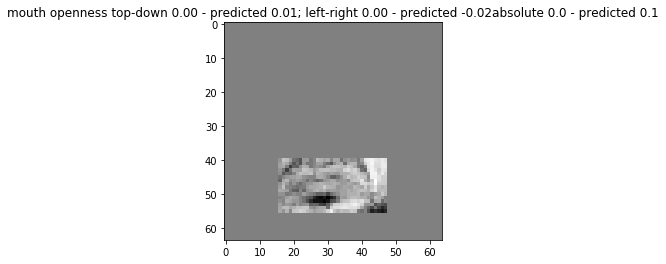

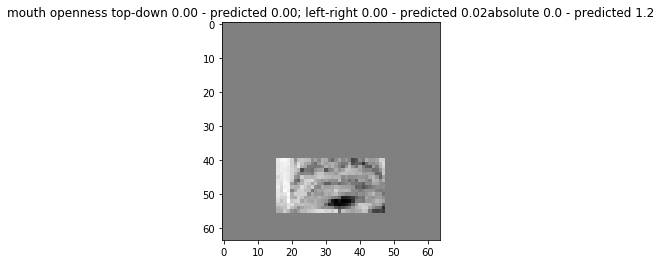

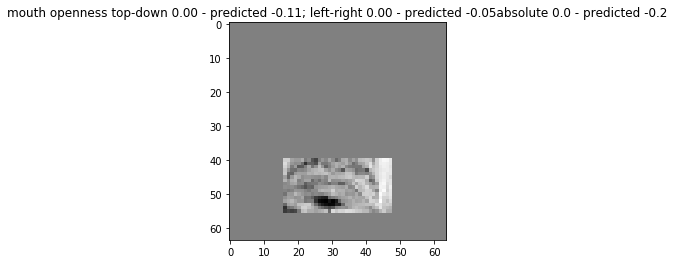

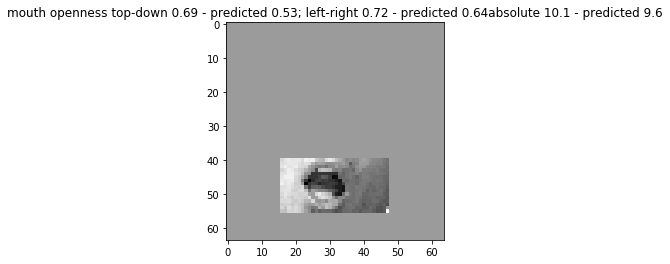

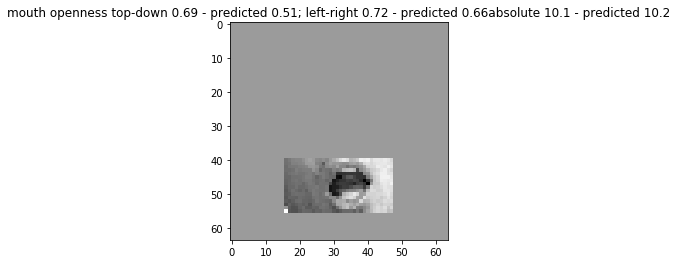

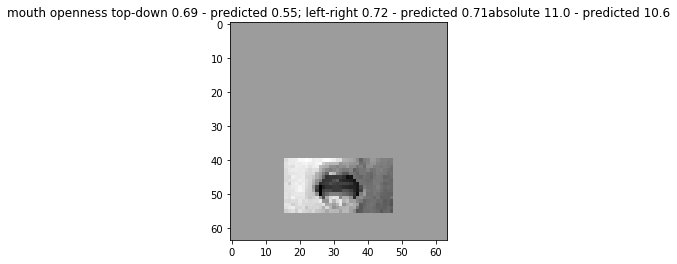

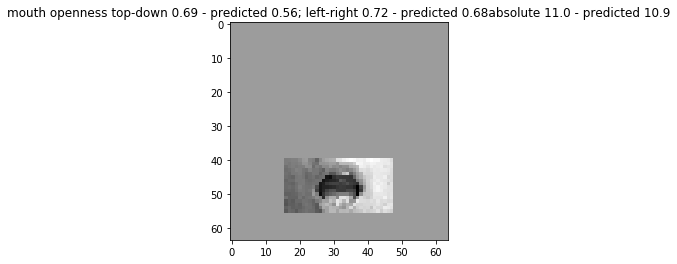

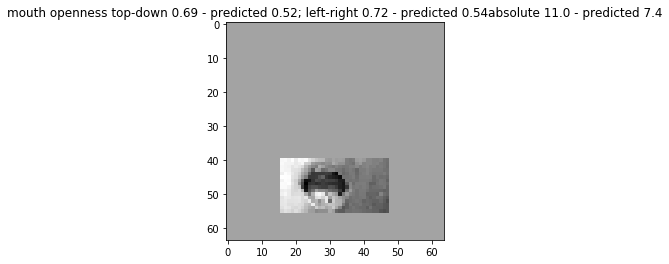

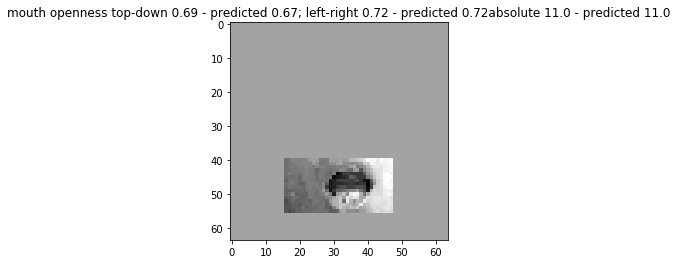

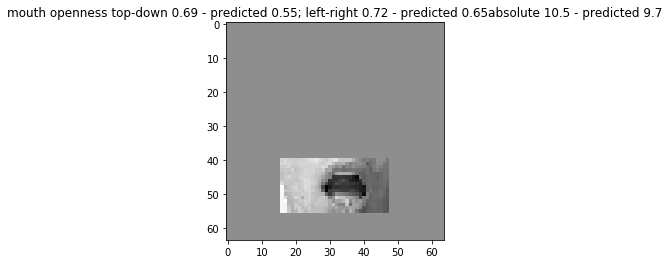

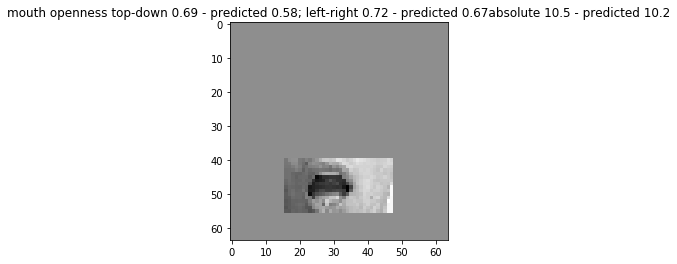

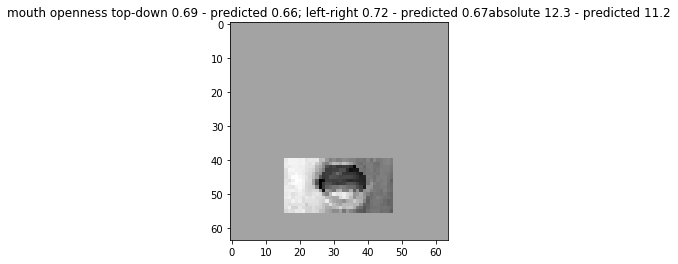

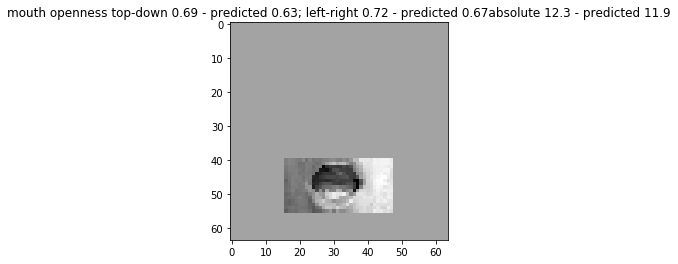

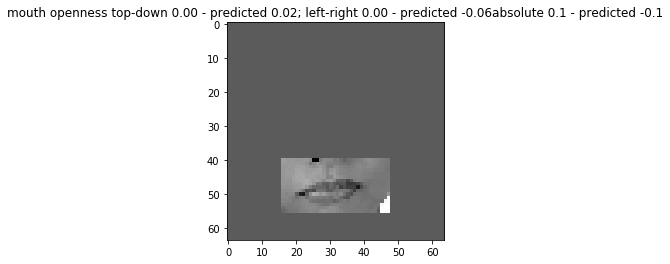

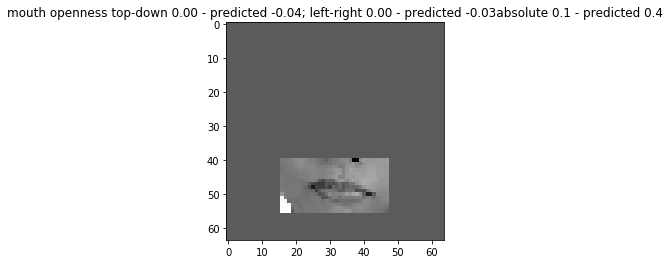

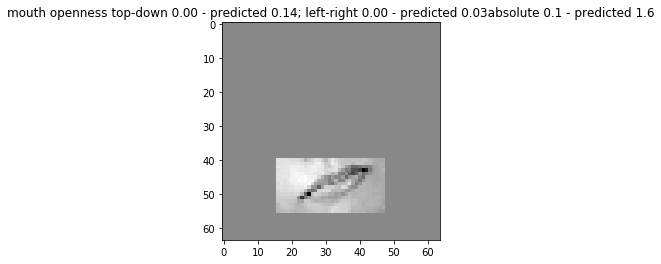

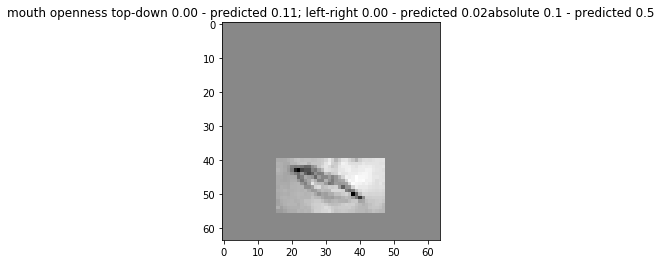

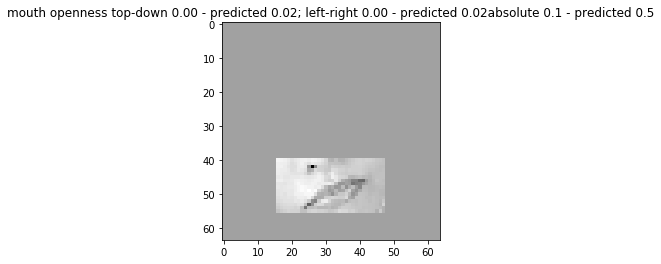

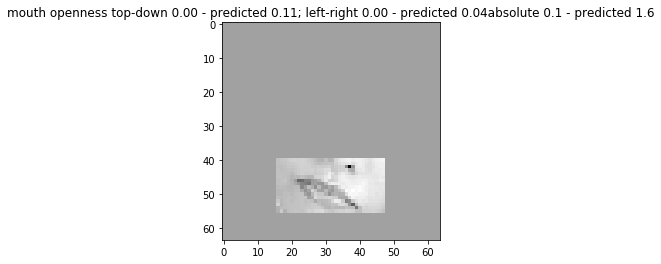

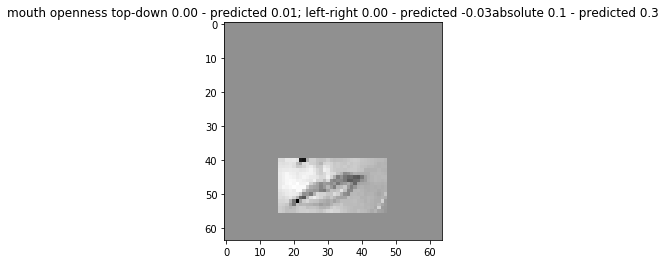

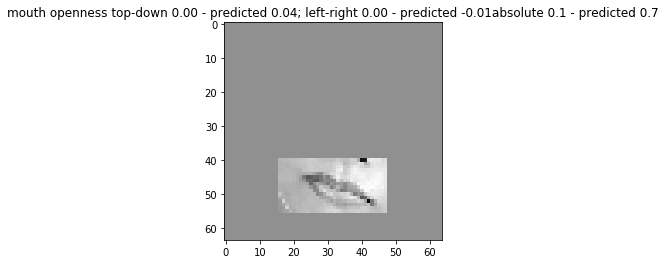

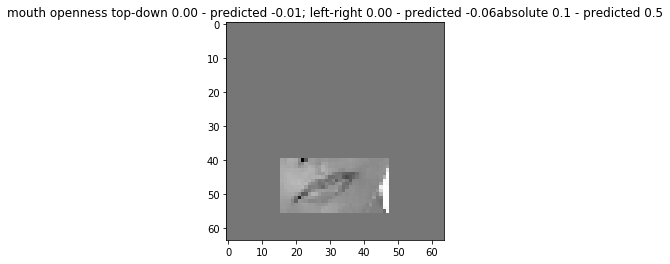

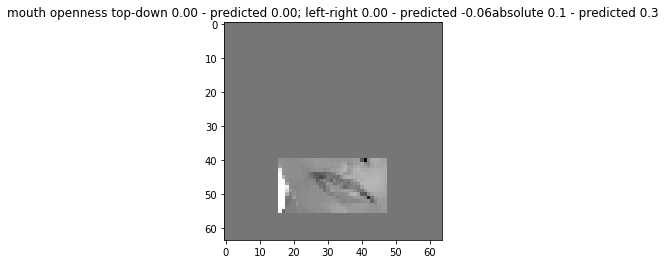

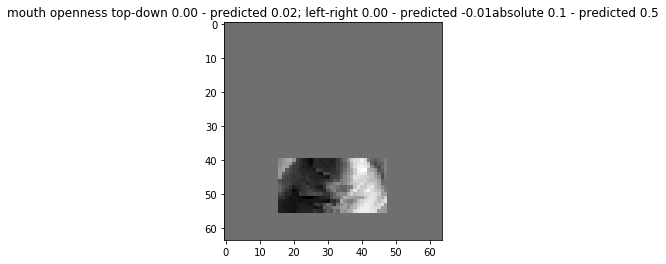

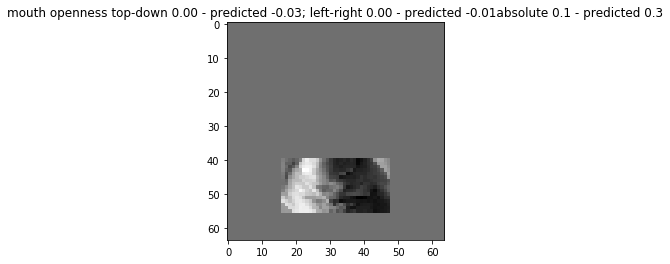

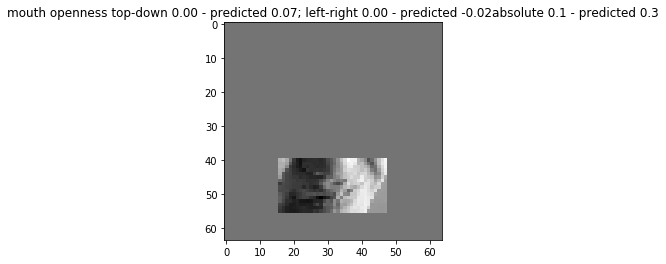

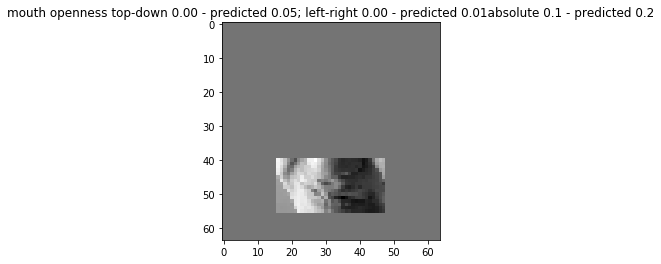

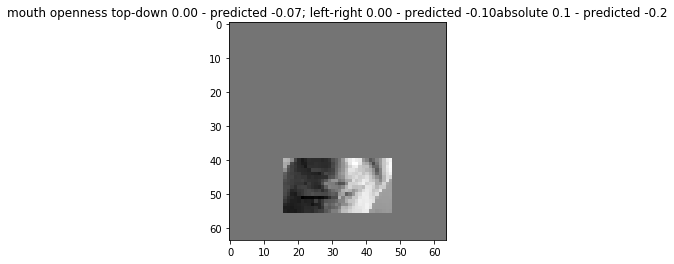

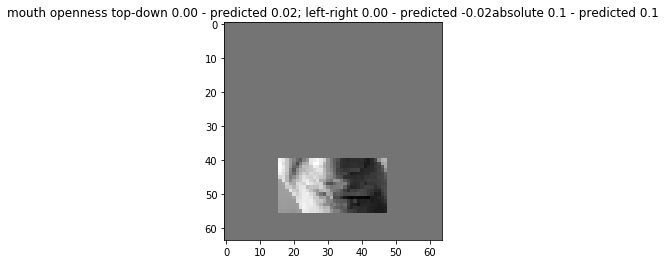

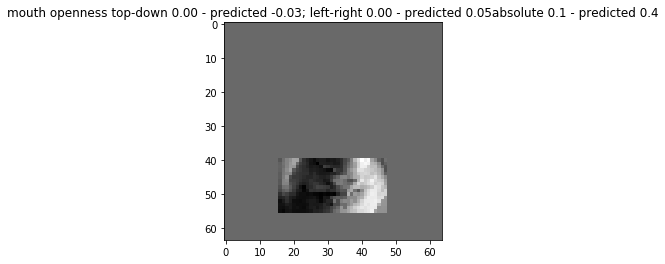

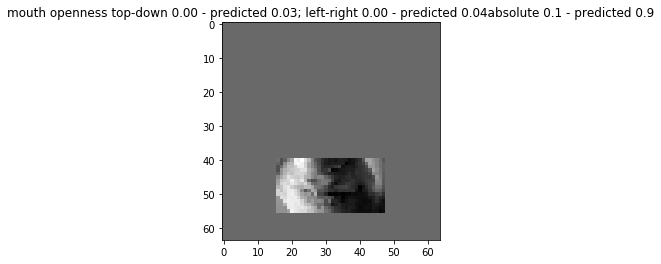

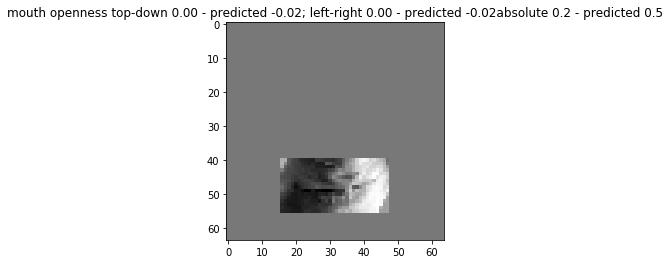

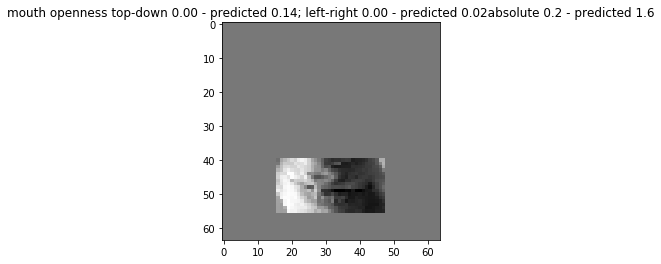

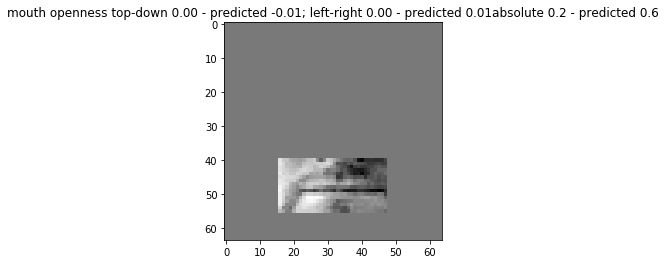

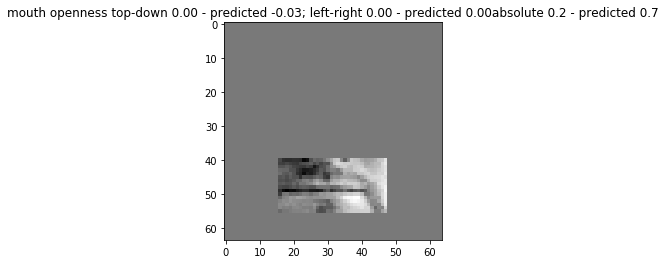

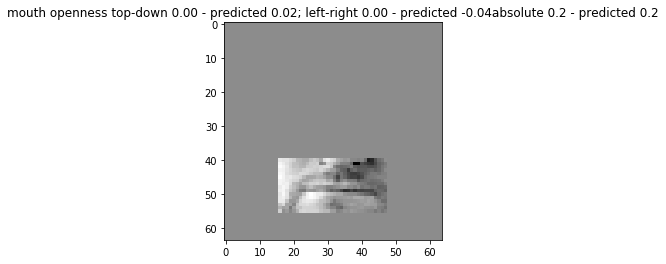

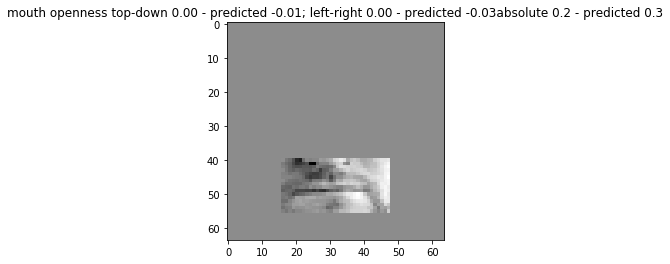

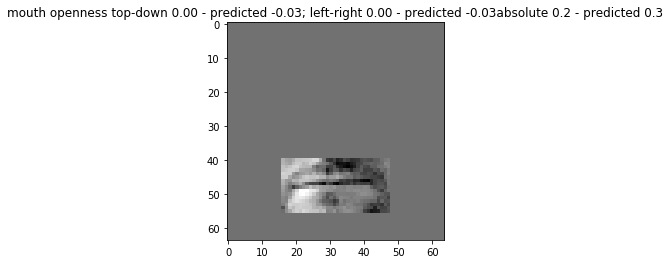

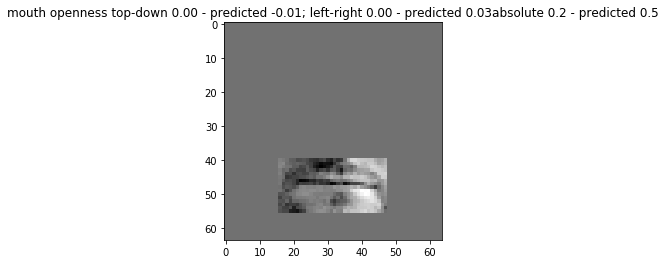

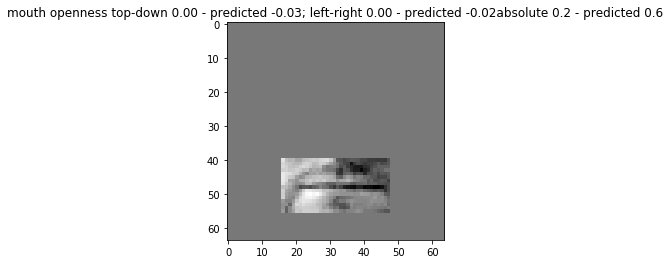

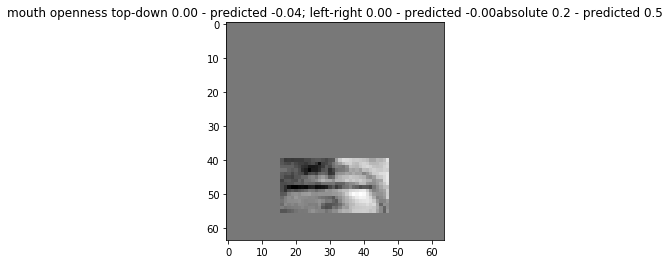

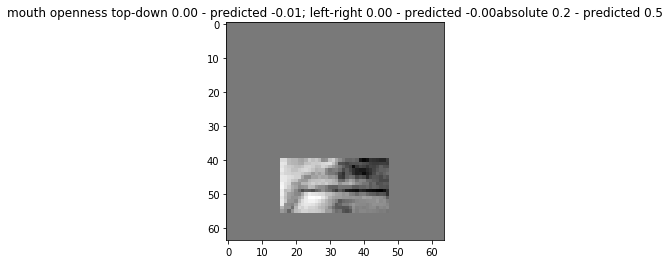

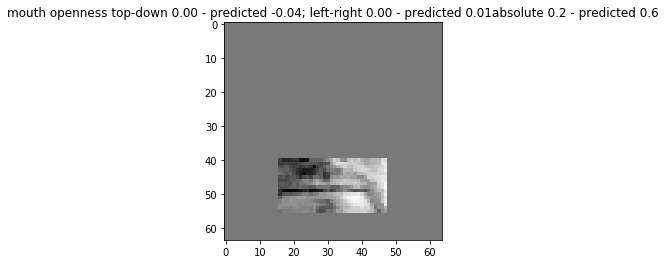

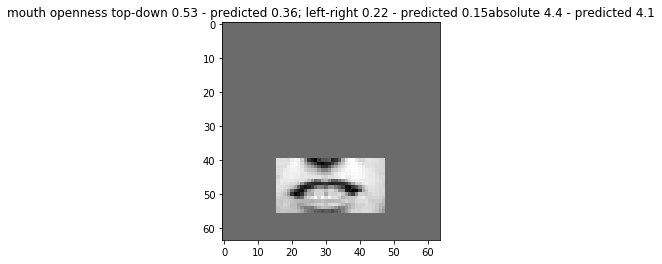

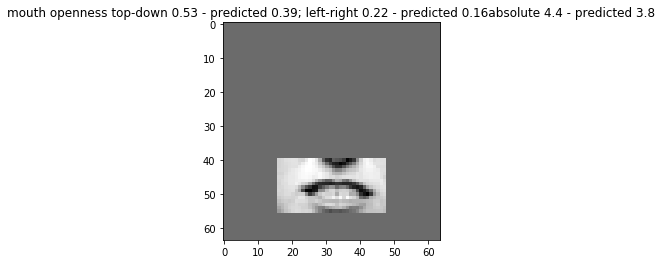

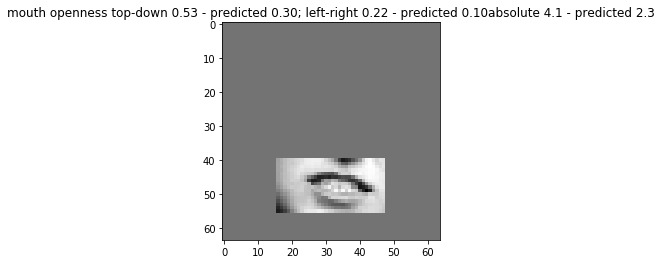

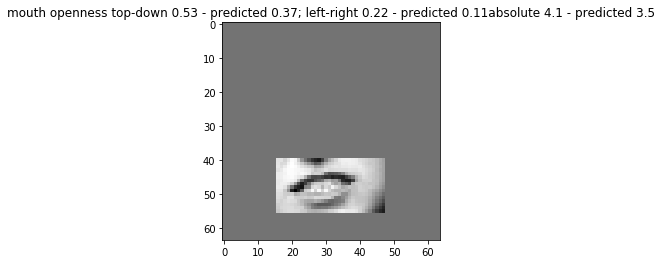

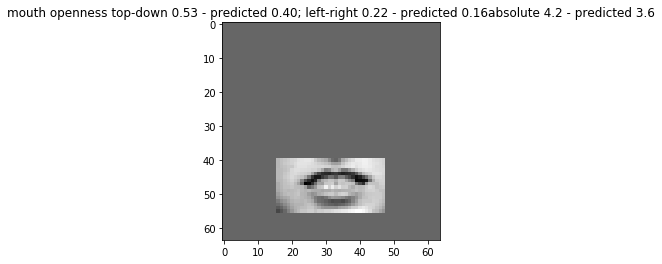

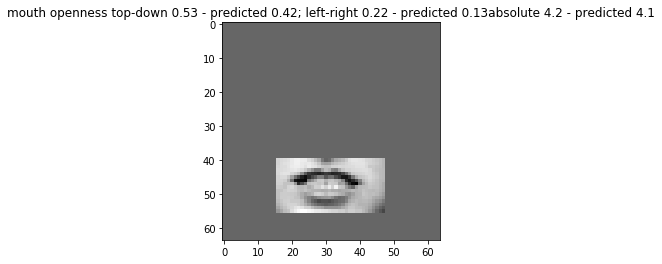

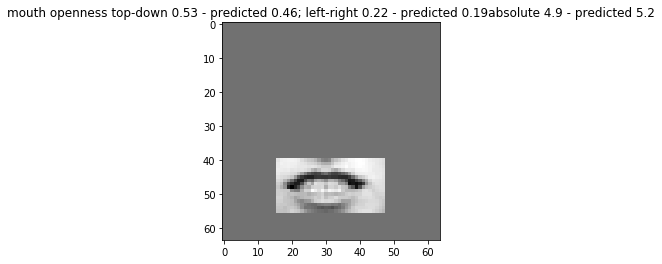

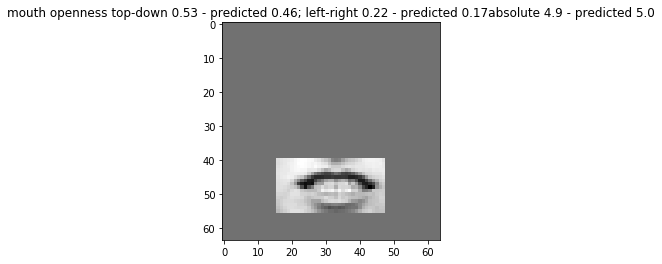

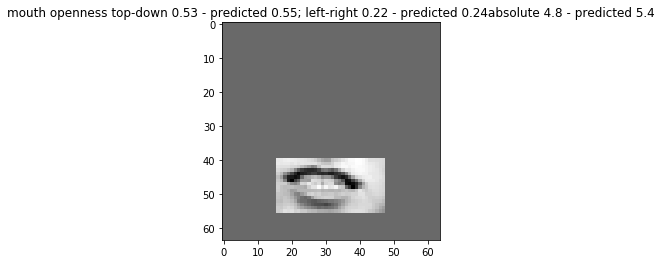

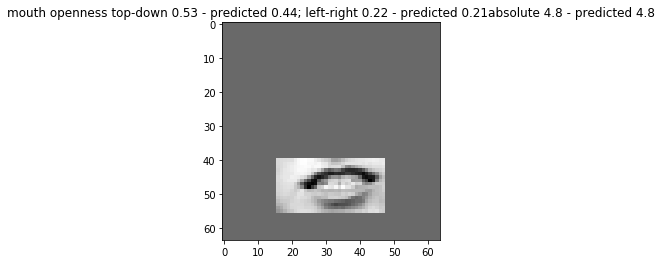

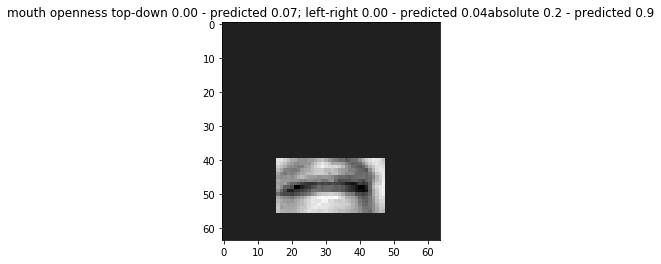

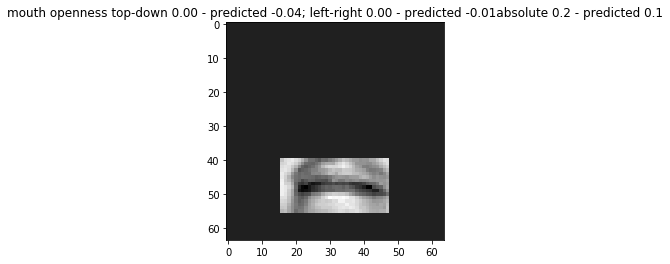

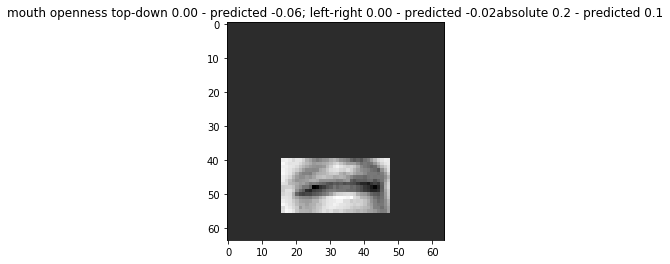

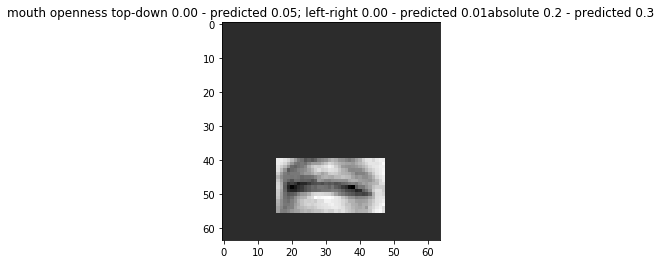

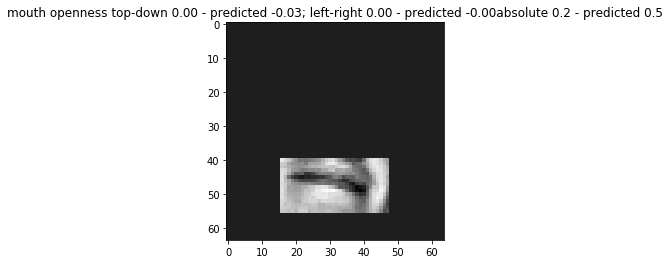

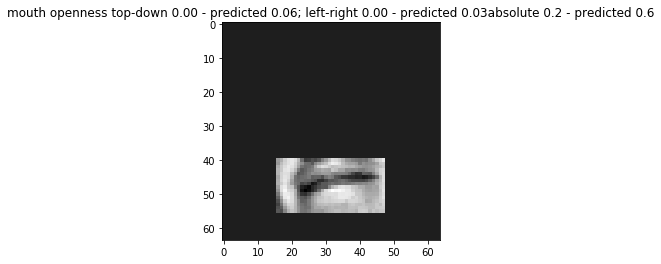

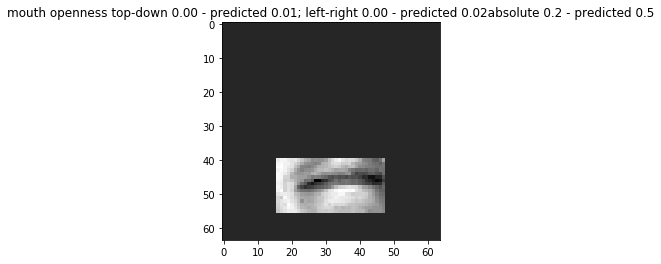

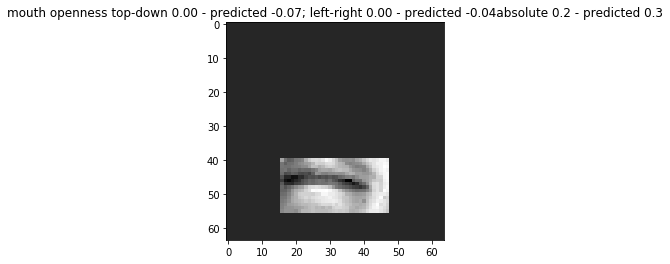

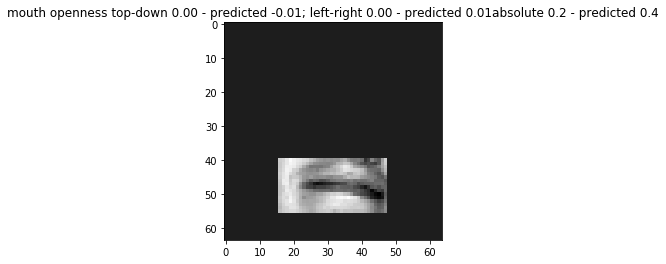

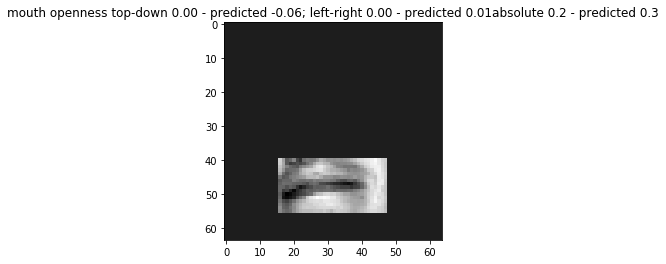

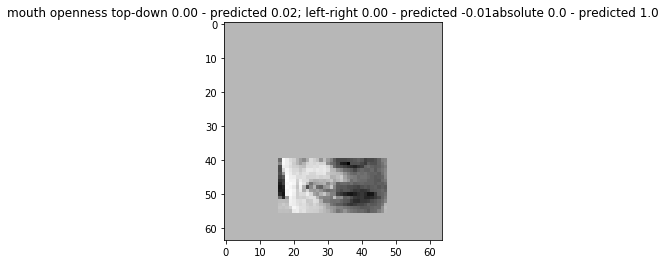

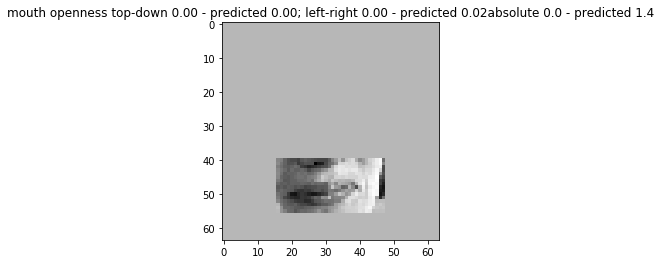

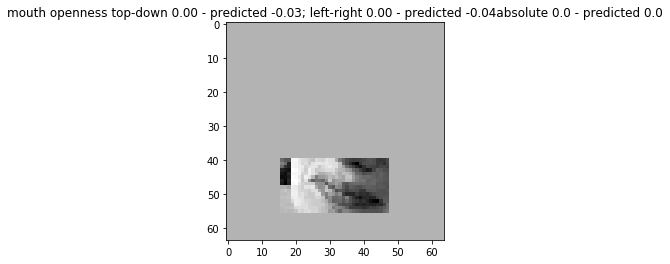

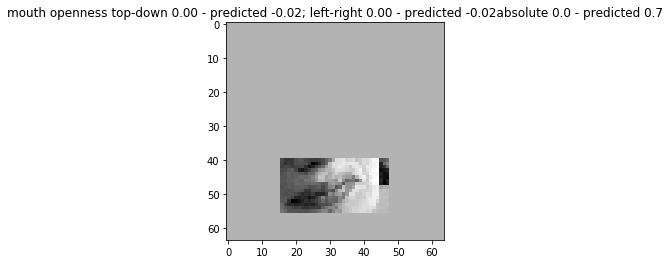

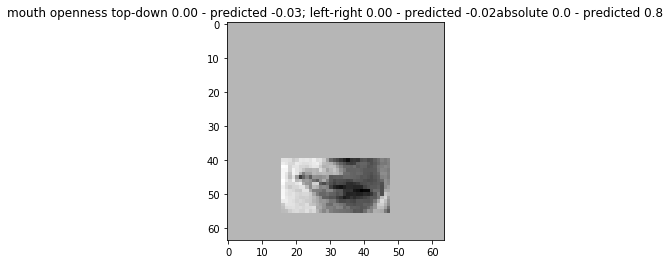

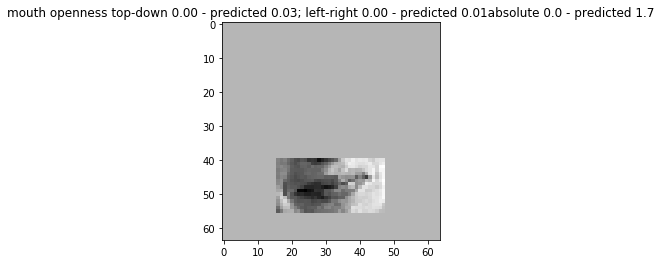

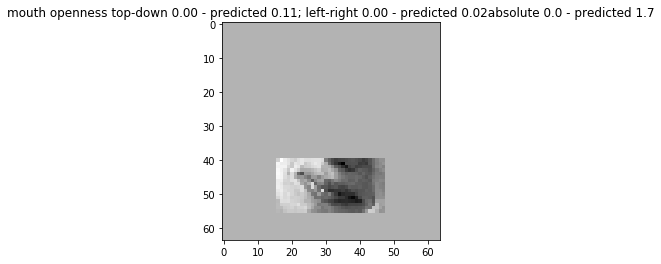

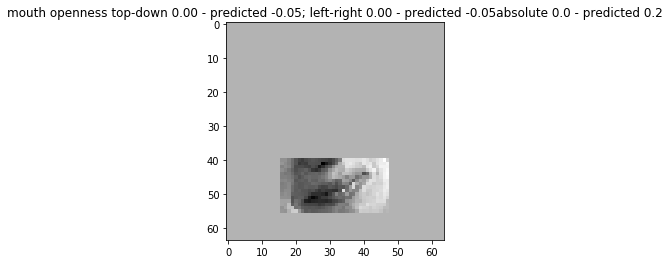

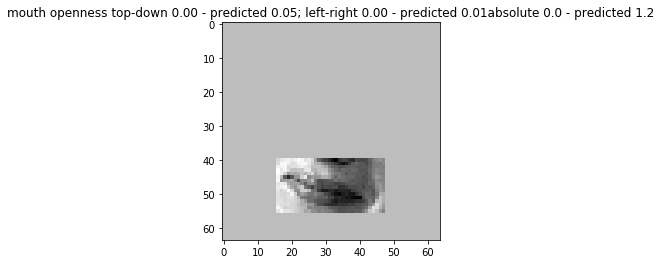

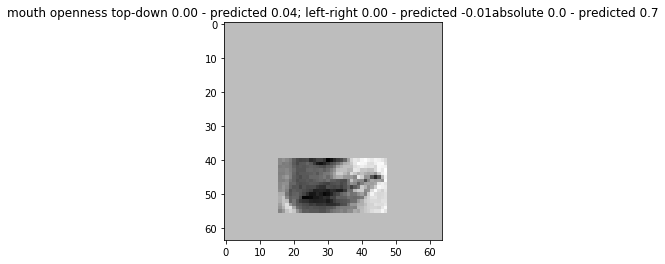

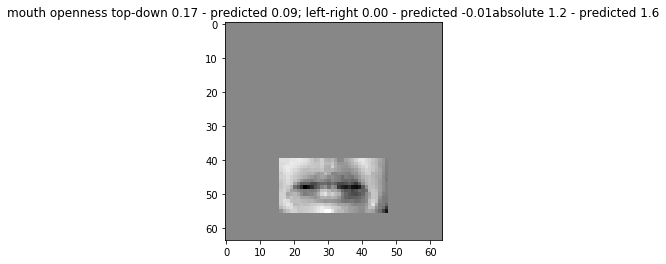

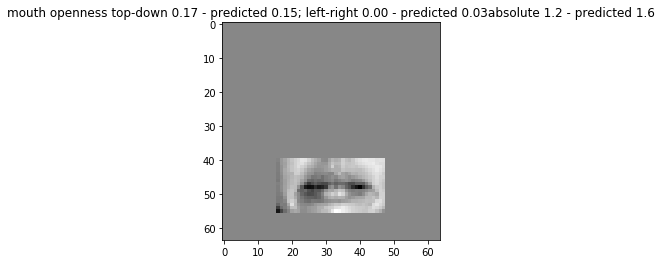

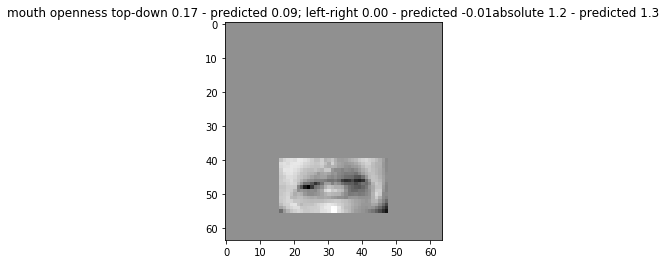

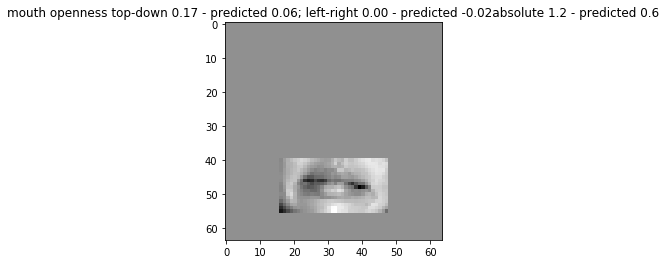

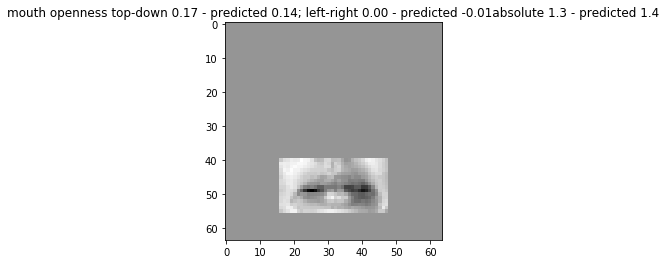

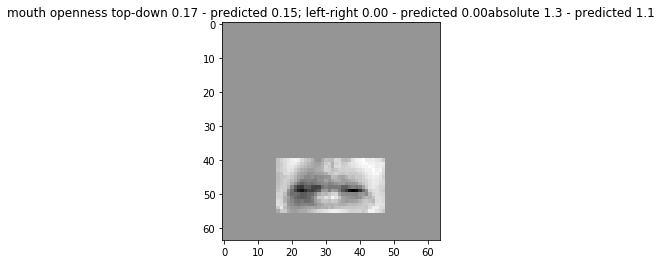

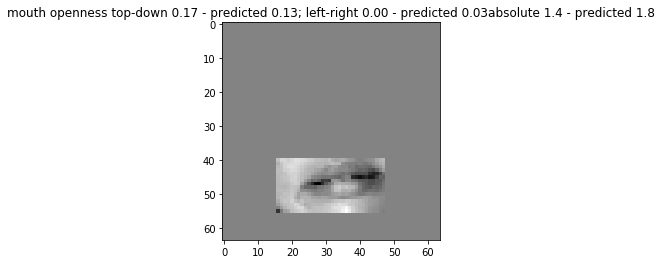

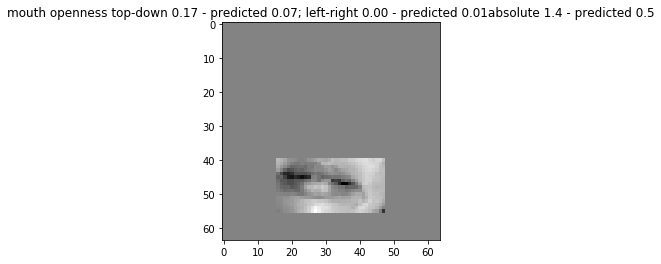

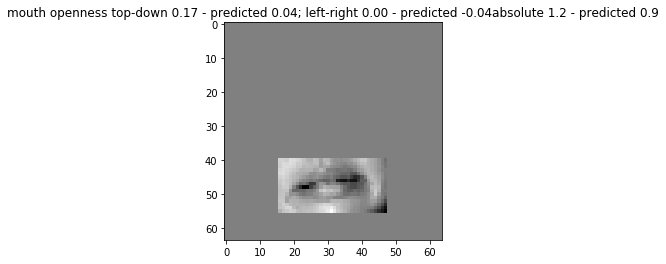

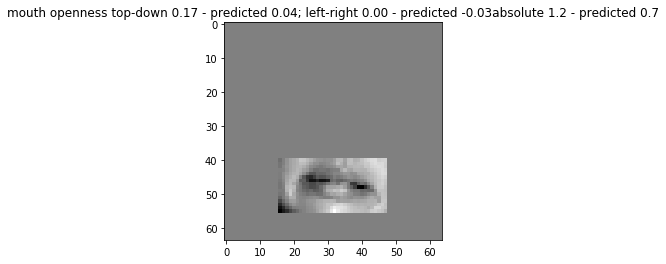

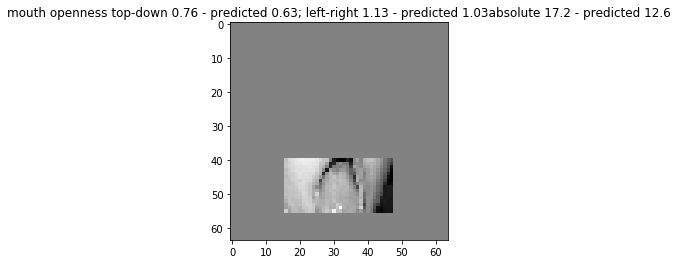

In [7]:
counter = 0
for i in sorted(mouth_dict.keys()):
    counter += 1
    debug_img = mouth_dict[i].copy()
    filename = i.split('_augment_')[0]
    plt.imshow(debug_img, cmap='gray')
    plt.title('mouth openness top-down {:01.2f} - predicted {:01.2f}; '\
    'left-right {:01.2f} - predicted {:01.2f} '\
    'absolute {:01.1f} - predicted {:01.1f}'.format(
        mouth_openness_top_down[filename], 
        clf_0.predict([list(add_dict[i])])[0],
        mouth_openness_left_right[filename],
        clf_1.predict([list(add_dict[i])])[0],
        mouth_openness_absolute[i],
        clf_2.predict([list(add_dict[i])])[0],
    ))
    plt.show()
    if counter > 100:
        break

In [16]:
print(list(clf_0.coef_))
print(list(clf_0.intercept_))
print(list(clf_1.coef_))
print(list(clf_1.intercept_))

[-0.0770459617571122, 0.002172780450665122, 0.0075500473258690625, 0.002810286324107149, -0.020178363414494062, 0.0019487933733380216, 0.07404247616733371, 0.006957743302276133, 0.018542366002419108, -0.013296758712057826, 0.042543155502578624, 0.0011259497592271768, -0.018311137471295102, -0.008680143330543, 0.061281425223244576, 0.056437265606277334, 0.030238832764363042, 0.004998656437368151, -0.014558201317150406, -0.004098066812995035, -0.02651638215414232, 0.0013863809890696426, 0.004680721426778659, -0.0712922052725895, 0.023345755230363734, 7.935839860589218e-06, 0.004981842356371966, -0.02560503626139906, -0.0010022932884865953, 0.0038529435516211456, -0.0014496873428008646, -0.07814652445302563, -0.021460922860113786, -0.005731457249194042, -0.005693907810659475, 0.00992780910496678, -0.005135953822933255, 0.0003297515571190425, 0.0005436884099817552, -0.011401283559642227, -0.005263068600277894, 0.013358085206788542, 0.04904899279527526, -0.04340576515128511, -0.011378329855

In [8]:
print(list(clf_2.coef_))
print(list(clf_2.intercept_))

[0.1311634407047403, 0.07501245445054212, 0.09127003910613432, 0.03686645638150222, -0.021178267457298547, 0.039003262465117906, -0.4664650113712809, 0.11022798389379593, 0.3078783366698439, -0.030115535405015288, 0.43361472017150965, -0.07628058953239036, -0.031043607456634804, 0.04402024829636944, 0.5839734691799899, -0.2751311561858966, -0.4185645400222439, 0.005029387174486781, 0.005544703184693264, -0.1332754625303883, 0.3302989502324398, -0.036586730873987935, 0.07410528675682038, -0.3879196938165776, 0.4340765559617426, -0.16528664660180784, 0.08217633023058525, -0.17954380048541474, -0.18298772056624205, 0.022841814494574533, -0.08363879918131578, -0.030855151360561172, -0.056800189923208795, -0.07249156829404102, -0.12010298863879186, 0.3342316482831686, -0.1392910531495698, -0.1304202762534214, 0.13568835809271335, 0.0679168173725711, -0.13818372304221385, -0.010655808128315401, 0.2336287955899402, 0.0281294671447561, 0.008869272950245635, -0.05967234434529209, -0.05442467539